In [2]:
:dep plotly = { version = "=0.8.0" } # 0.8.1 has breaking changes
:dep itertools-num = "0.1.3"
:dep num = "0.4.0"

In [3]:
#![allow(warnings)]

In [4]:
use itertools_num::linspace;
use plotly::common::{
    ColorScale, ColorScalePalette, DashType, Fill, Font, Line, LineShape, Marker, Mode, Title,
};
use plotly::layout::{Axis, BarMode, Layout, Legend, TicksDirection};
use plotly::{Bar, Plot, Scatter};

In [16]:
use core::f32::consts::PI;

/// fs:      samplerate
/// f:       frequency in hz
/// phi:     starting phase
/// samples: number of samples
fn sinusoid(fs: f32, f: f32, phi: f32, samples: usize) -> Vec<f32> {
    let T = 1. / fs;
    let w = 2. * PI * f;
    
    let mut ys = vec![0.0; samples];
    for (x, y) in ys.iter_mut().enumerate() {
        let x = x as f32;
        *y = (w * x * T + phi).cos();
    } 
    ys
}

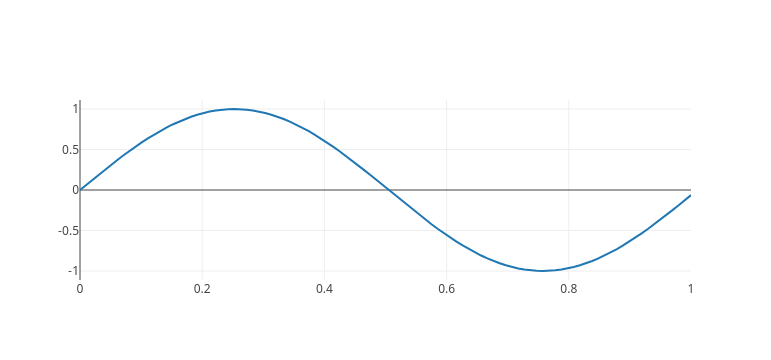

In [17]:
let fs = 100.;
let f = 1.;
let phi = -PI / 2.;
let samples = fs as usize;
let t = samples as f32 / fs;

// plot it
// let xs: Vec<f32> = linspace(0., (samples - 1) as f32, samples).collect();
let xs: Vec<f32> = linspace(0., t, samples).collect();

let ys_sinusoid = sinusoid(fs, f, phi, samples);

let mut plot = Plot::new();
plot.add_trace(Scatter::new(xs.clone(), ys_sinusoid).mode(Mode::Lines).name("sinusoid"));

plot.set_layout(Layout::new().height(400));
plot.lab_display();

In [164]:
/// aka log2_int aka ceil_log2
fn bit_length(n: usize) -> usize {
    (n as f64).log2().ceil() as usize
}


/// TS is sample type
/// TA is accumulator type
struct Nco {
    lut:        Vec<f32>,
    lut_length: usize,

    mask_index: u32,      // aka 512 = 512 - 1 = 0b1_1111_1111
    bits_index: u32,      // aka bit_length(lut_length) = 9
    bits_phi:   u32,      // aka bit_length(u32)        = 32
    
    max_phi:    u32,      // aka 2^(32-1)               = 2147483648
    two_pi:     u32,      // aka 2*max_phi

    phi:        u32,
    delta_phi:  u32,
}

impl Nco {
    fn new(lut_length: usize) -> Self {
        let mut lut = vec![0.0; lut_length];
        for (x, y) in lut.iter_mut().enumerate() {
            let x = x as f32;
            *y = ((2. * PI * x) / (lut_length as f32)).cos();
        }

        let mask_index = lut_length as u32 - 1;  // 512 = 0b1_1111_1111
        let bits_index = bit_length(lut_length) as u32;
        let bits_phi = std::mem::size_of::<u32>() as u32 * 8;
        let max_phi  = 1 << (bits_phi - 1);
        let two_pi   = u32::MAX; //max_phi * 2; TODO overflow!

        println!("lut_length: {}  mask_index: {:b}  bits_index: {}  bits_phi: {}  max_phi: {}  two_pi: {}", 
                 lut_length, mask_index, bits_index, bits_phi, max_phi, two_pi);
        
        Self {
            lut,
            lut_length,

            mask_index,
            bits_index,
            bits_phi,
            max_phi,
            two_pi,
            
            phi: 0,
            delta_phi: 0,
        }
    }

    fn set_frequency(&mut self, fs: f32, frequency: f32) {
        self.delta_phi = (frequency * (self.two_pi as f32 / fs)) as u32;
        //self.delta_phi = (frequency as u32 * (self.two_pi / fs as u32)) as u32;
        println!("delta_phi: {}", self.delta_phi);
    }

    fn step(&mut self) -> f32 {
        // grab our index from the top `bits_index` bits of the accumulator
        let index = self.phi >> (self.bits_phi - self.bits_index);
        
        // mask index
        let index = index & self.mask_index;

        // TODO use fractional parts of accumulator?
        let sample = self.lut[index as usize];

        // increment accumulator phase
        self.phi = self.phi.wrapping_add(self.delta_phi);      
        
        sample
    }

    fn reset(&mut self) {
        self.phi = 0;
    }
}

// 2^32 = 4294967296


lut_length: 512  mask_index: 111111111  bits_index: 9  bits_phi: 32  max_phi: 2147483648  two_pi: 4294967295
delta_phi: 39370532


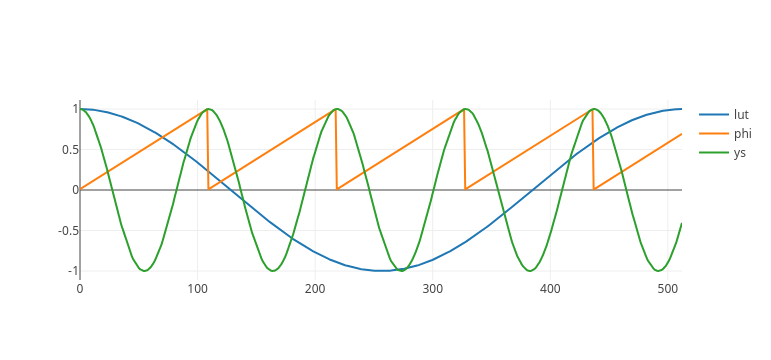

In [165]:
let fs = 512.;
let lut_length = fs as usize;

let xs: Vec<f32> = linspace(0., fs, lut_length).collect();

let mut nco = Nco::new(lut_length);
//nco.set_frequency(48000., 93.75); 
//nco.set_frequency(48000., 187.); 
nco.set_frequency(48000., 440.); 
let ys_lut = nco.lut.clone();

let mut ys_phi = vec![0.0; lut_length];
for (x, y) in ys_phi.iter_mut().enumerate() {
    let sample = nco.step();
    let phi_max = u32::MAX; //1 << (std::mem::size_of::<u32>() * 8);
    *y = nco.phi as f32 / phi_max as f32;
}

nco.reset();

let mut ys = vec![0.0; lut_length];
for (x, y) in ys.iter_mut().enumerate() {
    *y = nco.step();
}

let mut plot = Plot::new();
plot.add_trace(Scatter::new(xs.clone(), ys_lut).mode(Mode::Lines).name("lut"));
plot.add_trace(Scatter::new(xs.clone(), ys_phi).mode(Mode::Lines).name("phi"));
plot.add_trace(Scatter::new(xs.clone(), ys).mode(Mode::Lines).name("ys"));


plot.set_layout(Layout::new().height(400));
plot.lab_display();


